In [1]:
!pip install dateparser
!pip install python-binance

In [3]:
#importing dependencies
import gc
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from binance.client import Client

import keras
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout

  # Setting up hyper parameters and global variables for our model:
  
neurons = 1024                 # number of hidden units in the LSTM layer
activation_function = 'tanh'  # activation function for LSTM and Dense layer
loss = 'mse'                  # loss function for calculating the gradient, in this case Mean Squared Error
optimizer= 'adam'             # optimizer for appljying gradient decent
dropout = 0.25                # dropout ratio used after each LSTM layer to avoid overfitting
batch_size = 128              
epochs = 53                  
window_len = 3               # is an intiger to be used as the look back window for creating a single input sample.
training_size = 0.8           # porportion of data to be used for training
merge_date = '2017-01-01'     # the earliest date which we have data for both ETH and BTC or any other provided coin

#Initial variables for binance

client = Client("", "")
tag="BTC"
reference_tag="USDT"
binance_tag=tag+reference_tag


Using TensorFlow backend.


In [0]:
#define the function that gets the data from binance

def get_market_data(binance_tag, tag=True):
  """
  Kline/candlestick bars for a symbol. Klines are uniquely identified by their open time.
  https://github.com/binance-exchange/binance-official-api-docs/blob/master/rest-api.md#klinecandlestick-data
  :param symbol: required
  :type symbol: str
  :param interval: -
  :type interval: str
  :param limit: - Default 500; max 500.
  :type limit: int
  :param startTime:
  :type startTime: int
  :param endTime:
  :type endTime: int
  :returns: API response
  .. code-block:: python
      [
          [
              1499040000000,      # Open time
              "0.01634790",       # Open
              "0.80000000",       # High
              "0.01575800",       # Low
              "0.01577100",       # Close
              "148976.11427815",  # Volume
              1499644799999,      # Close time
              "2434.19055334",    # Quote asset volume
              308,                # Number of trades
              "1756.87402397",    # Taker buy base asset volume
              "28.46694368",      # Taker buy quote asset volume
              "17928899.62484339" # Can be ignored
          ]
      ]
  :raises: BinanceRequestException, BinanceAPIException
  """

  klines = client.get_historical_klines(tag+"USDT", Client.KLINE_INTERVAL_12HOUR, "1 Apr, 2018")
  data=np.array(klines)
  temp_data=data.reshape(-1,12)
  market_data=pd.DataFrame(temp_data, columns=['Date', 'Open', 'High', 'Low', 'Close', 'Volume','Close time', 'Quote asset volume', 'Number of trades', 'Taker buybase asset volume', 'Taker buy quote asset volume', 'Can be ignored'])
  market_data = market_data.assign(Date=pd.to_datetime(market_data['Date'], unit='ms'))  
  market_data['Volume'] = (pd.to_numeric(market_data['Volume'], errors='coerce').fillna(0))
  market_data['Open'] = (pd.to_numeric(market_data['Open'], errors='coerce').fillna(0))
  market_data['Close'] = (pd.to_numeric(market_data['Close'], errors='coerce').fillna(0))
  if tag:
    market_data.columns = [market_data.columns[0]] + [tag + '_' + i for i in market_data.columns[1:]]
  return market_data


def merge_data(a, b, from_date=merge_date):
  """
  a: first DataFrame
  b: second DataFrame
  from_date: includes the data from the provided date and drops the any data before that date.
  returns merged data as Pandas DataFrame
  """
  merged_data = pd.merge(a, b, on=['Date'])
  merged_data = merged_data[merged_data['Date'] >= from_date]
  return merged_data


def add_volatility(data, coins=['BTC', 'ETH']):
  """
  data: input data, pandas DataFrame
  coins: default is for 'btc and 'eth'. It could be changed as needed
  This function calculates the volatility and close_off_high of each given coin in 24 hours, 
  and adds the result as new columns to the DataFrame.
  Return: DataFrame with added columns
  """
  for coin in coins:
    # calculate the daily change
    kwargs = {coin + '_change': lambda x: (x[coin + '_Close'] - x[coin + '_Open']) / x[coin + '_Open'],
             coin + '_close_off_high': lambda x: 2*(x[coin + '_High'] - x[coin + '_Close']) / (x[coin + '_High'] - x[coin + '_Low']) - 1,
             coin + '_volatility': lambda x: (x[coin + '_High'] - x[coin + '_Low']) / (x[coin + '_Open'])}
    data = data.assign(**kwargs)
  return data


def create_model_data(data):
  """
  data: pandas DataFrame
  This function drops unnecessary columns and reverses the order of DataFrame based on decending dates.
  Return: pandas DataFrame
  """
  #data = data[['Date']+[coin+metric for coin in ['btc_', 'eth_'] for metric in ['Close','Volume','close_off_high','volatility']]]
  data = data[['Date']+[coin+metric for coin in ['BTC_', 'ETH_'] for metric in ['Close','Volume']]]
  data = data.sort_values(by='Date')
  return data


def split_data(data, training_size=0.8):
  """
  data: Pandas Dataframe
  training_size: proportion of the data to be used for training
  This function splits the data into training_set and test_set based on the given training_size
  Return: train_set and test_set as pandas DataFrame
  """
  return data[:int(training_size*len(data))], data[int(training_size*len(data)):]


def create_inputs(data, coins=['BTC', 'ETH'], window_len=window_len):
  """
  data: pandas DataFrame, this could be either training_set or test_set
  coins: coin datas which will be used as the input. Default is 'btc', 'eth'
  window_len: is an intiger to be used as the look back window for creating a single input sample.
  This function will create input array X from the given dataset and will normalize 'Close' and 'Volume' between 0 and 1
  Return: X, the input for our model as a python list which later needs to be converted to numpy array.
  """
  norm_cols = [coin + metric for coin in coins for metric in ['_Close', '_Volume']]
  inputs = []
  for i in range(len(data) - window_len):
    temp_set = data[i:(i + window_len)].copy()
    inputs.append(temp_set)
    for col in norm_cols:
      inputs[i].loc[:, col] = inputs[i].loc[:, col] / inputs[i].loc[:, col].iloc[0] - 1  
  return inputs


def create_outputs(data, coin, window_len=window_len):
  """
  data: pandas DataFrame, this could be either training_set or test_set
  coin: the target coin in which we need to create the output labels for
  window_len: is an intiger to be used as the look back window for creating a single input sample.
  This function will create the labels array for our training and validation and normalize it between 0 and 1
  Return: Normalized numpy array for 'Close' prices of the given coin
  """
  return (data[coin + '_Close'][window_len:].values / data[coin + '_Close'][:-window_len].values) - 1

#changing to numpy array

def to_array(data):
  """
  data: DataFrame
  This function will convert list of inputs to a numpy array
  Return: numpy array
  """
  x = [np.array(data[i]) for i in range (len(data))]
  return np.array(x)



In [6]:
btc_data=get_market_data(binance_tag, tag='BTC')
eth_data=get_market_data(binance_tag, tag='ETH')
eth_data.head()

,Date,ETH_Open,ETH_High,ETH_Low,ETH_Close,ETH_Volume,ETH_Close time,ETH_Quote asset volume,ETH_Number of trades,ETH_Taker buybase asset volume,ETH_Taker buy quote asset volume,ETH_Can be ignored
0,2018-04-01 00:00:00,393.93,399.91000000,371.70000000,374.65,50237.98671,1522583999999,19246940.39259990,43455,23949.76449000,9177622.15652630,0
1,2018-04-01 12:00:00,374.97,388.00000000,356.90000000,378.58,100256.00751,1522627199999,37373237.96174080,75874,48019.68141000,17895612.49832440,0
2,2018-04-02 00:00:00,378.58,394.87000000,375.05000000,391.79,60996.52683,1522670399999,23508902.71957170,49107,35864.78132000,13814829.79767670,0
3,2018-04-02 12:00:00,391.55,392.00000000,375.00000000,385.05,52245.61508,1522713599999,20087955.78289950,46703,25053.31857000,9641481.52197300,0
4,2018-04-03 00:00:00,385.00,404.74000000,380.13000000,397.52,68664.83470,1522756799999,27086312.41094780,59828,36631.41443000,14452038.46979120,0


In [0]:

#building the model

def build_model(inputs, output_size, neurons, activ_func=activation_function, dropout=dropout, loss=loss, optimizer=optimizer):
  """
  inputs: input data as numpy array
  output_size: number of predictions per input sample
  neurons: number of neurons/ units in the LSTM layer
  active_func: Activation function to be used in LSTM layers and Dense layer
  dropout: dropout ration, default is 0.25
  loss: loss function for calculating the gradient
  optimizer: type of optimizer to backpropagate the gradient
  This function will build 3 layered RNN model with LSTM cells with dripouts after each LSTM layer 
  and finally a dense layer to produce the output using keras' sequential model.
  Return: Keras sequential model and model summary
  """
  model = Sequential()
  model.add(LSTM(neurons, return_sequences=True, input_shape=(inputs.shape[1], inputs.shape[2]), activation=activ_func))
  model.add(Dropout(dropout))
  model.add(LSTM(neurons, return_sequences=True, activation=activ_func))
  model.add(Dropout(dropout))
  model.add(LSTM(neurons, return_sequences=True, activation=activ_func))
  model.add(Dropout(dropout))
  model.add(LSTM(neurons, activation=activ_func))
  model.add(Dropout(dropout))
  model.add(Dense(units=output_size))
  model.add(Activation(activ_func))
  model.compile(loss=loss, optimizer=optimizer, metrics=['mae'])
  model.summary()
  return model

In [0]:
#functions for ploting

def show_plot(data, tag):
  fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[3, 1]})
  ax1.set_ylabel('Closing Price ($)',fontsize=12)
  ax2.set_ylabel('Volume ($ bn)',fontsize=12)
  ax2.set_yticks([int('%d000000000'%i) for i in range(10)])
  ax2.set_yticklabels(range(10))
  ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
  ax1.set_xticklabels('')
  ax2.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
  ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,7]])
  ax1.plot(data['Date'].astype(datetime.datetime),data[tag +'_Open'])
  ax2.bar(data['Date'].astype(datetime.datetime).values, data[tag +'_Volume'].values)
  fig.tight_layout()
  plt.show()
  

def date_labels():
  last_date = market_data.iloc[0, 0]
  date_list = [last_date - datetime.timedelta(days=x) for x in range(len(X_test))]
  return[date.strftime('%m/%d/%Y') for date in date_list][::-1]


def plot_results(history, model, Y_target, coin):
  plt.figure(figsize=(25, 20))
  plt.subplot(311)
  plt.plot(history.epoch, history.history['loss'], )
  plt.plot(history.epoch, history.history['val_loss'])
  plt.xlabel('Number of Epochs')
  plt.ylabel('Loss')
  plt.title(coin + ' Model Loss')
  plt.legend(['Training', 'Test'])

  plt.subplot(312)
  plt.plot(Y_target)
  plt.plot(model.predict(X_train))
  plt.xlabel('Dates')
  plt.ylabel('Price')
  plt.title(coin + ' Single Point Price Prediction on Training Set')
  plt.legend(['Actual','Predicted'])

  ax1 = plt.subplot(313)
  plt.plot(test_set[coin + '_Close'][window_len:].values.tolist())
  plt.plot(((np.transpose(model.predict(X_test)) + 1) * test_set[coin + '_Close'].values[:-window_len])[0])
  plt.xlabel('Dates')
  plt.ylabel('Price')
  plt.title(coin + ' Single Point Price Prediction on Test Set')
  plt.legend(['Actual','Predicted'])
  
  date_list = date_labels()
  ax1.set_xticks([x for x in range(len(date_list))])
  for label in ax1.set_xticklabels([date for date in date_list], rotation='vertical')[::2]:
    label.set_visible(False)

  plt.show()

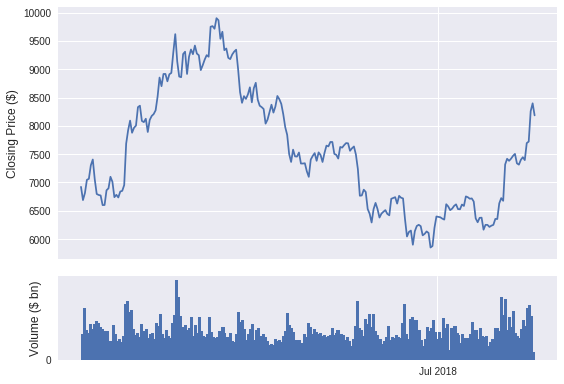

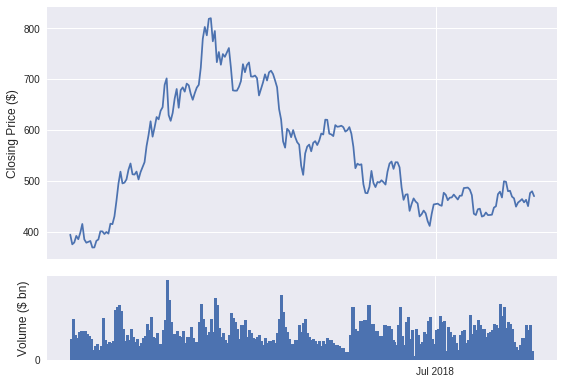

In [9]:
#not working, taking forever
show_plot(btc_data, tag='BTC')
show_plot(eth_data, tag='ETH')

In [0]:
market_data = merge_data(btc_data, eth_data)
model_data = create_model_data(market_data)
train_set, test_set = split_data(model_data)

In [11]:
train_set = train_set.drop('Date', 1)
test_set = test_set.drop('Date', 1)

X_train = create_inputs(market_data)
X_train = create_inputs(train_set)
Y_train_btc = create_outputs(train_set, coin='BTC')
X_test = create_inputs(test_set)
Y_test_btc = create_outputs(test_set, coin='BTC')

Y_train_eth = create_outputs(train_set, coin='ETH')
Y_test_eth = create_outputs(test_set, coin='ETH')

X_train, X_test = to_array(X_train), to_array(X_test)

print (np.shape(X_train), np.shape(X_test), np.shape(Y_train_btc), np.shape(Y_test_btc))
print (np.shape(X_train), np.shape(X_test), np.shape(Y_train_eth), np.shape(Y_test_eth))

((182, 3, 4), (44, 3, 4), (182,), (44,))
((182, 3, 4), (44, 3, 4), (182,), (44,))


In [39]:
eth_data.head()


,Date,ETH_Open,ETH_High,ETH_Low,ETH_Close,ETH_Volume,ETH_Close time,ETH_Quote asset volume,ETH_Number of trades,ETH_Taker buybase asset volume,ETH_Taker buy quote asset volume,ETH_Can be ignored
0,2017-08-17 04:00:00,4261.48,4280.56000000,4261.32000000,4261.45,11.308926,1502944199999,48224.75400837,49,3.93617400,16793.03995768,7922.57993329
1,2017-08-17 04:30:00,4280.00,4313.62000000,4267.99000000,4308.83,35.872083,1502945999999,154141.38438467,122,31.22432900,134159.43798536,7887.63551305
2,2017-08-17 05:00:00,4308.83,4328.69000000,4304.31000000,4320.00,21.048648,1502947799999,90864.29252042,73,19.39657000,83746.08374208,7863.87118389
3,2017-08-17 05:30:00,4320.00,4320.00000000,4291.37000000,4315.32,2.186268,1502949599999,9440.53104707,29,2.05150100,8862.19598628,8039.26240152
4,2017-08-17 06:00:00,4330.29,4330.29000000,4309.37000000,4311.02,3.566277,1502951399999,15409.76133301,14,2.30207700,9951.67338501,8049.59266729


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 3, 1024)           4214784   
_________________________________________________________________
dropout_5 (Dropout)          (None, 3, 1024)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 3, 1024)           8392704   
_________________________________________________________________
dropout_6 (Dropout)          (None, 3, 1024)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 3, 1024)           8392704   
_________________________________________________________________
dropout_7 (Dropout)          (None, 3, 1024)           0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 1024)              8392704   
__________

182/182 [==============================] - 4s 24ms/step - loss: 0.0020 - mean_absolute_error: 0.0333 - val_loss: 0.0023 - val_mean_absolute_error: 0.0339
Epoch 9/53
182/182 [==============================] - 4s 24ms/step - loss: 0.0019 - mean_absolute_error: 0.0329 - val_loss: 0.0021 - val_mean_absolute_error: 0.0315
Epoch 10/53
182/182 [==============================] - 4s 24ms/step - loss: 0.0019 - mean_absolute_error: 0.0323 - val_loss: 0.0019 - val_mean_absolute_error: 0.0308
Epoch 11/53
182/182 [==============================] - 4s 24ms/step - loss: 0.0019 - mean_absolute_error: 0.0322 - val_loss: 0.0019 - val_mean_absolute_error: 0.0309
Epoch 12/53
182/182 [==============================] - 4s 24ms/step - loss: 0.0018 - mean_absolute_error: 0.0320 - val_loss: 0.0021 - val_mean_absolute_error: 0.0317
Epoch 13/53
182/182 [==============================] - 4s 24ms/step - loss: 0.0018 - mean_absolute_error: 0.0321 - val_loss: 0.0022 - val_mean_absolute_error: 0.0330
Epoch 14/53
182/1

182/182 [==============================] - 4s 24ms/step - loss: 0.0015 - mean_absolute_error: 0.0282 - val_loss: 0.0018 - val_mean_absolute_error: 0.0300
Epoch 28/53
182/182 [==============================] - 4s 24ms/step - loss: 0.0014 - mean_absolute_error: 0.0274 - val_loss: 0.0016 - val_mean_absolute_error: 0.0281
Epoch 29/53
182/182 [==============================] - 4s 24ms/step - loss: 0.0013 - mean_absolute_error: 0.0260 - val_loss: 0.0023 - val_mean_absolute_error: 0.0342
Epoch 30/53
182/182 [==============================] - 4s 24ms/step - loss: 0.0016 - mean_absolute_error: 0.0292 - val_loss: 0.0013 - val_mean_absolute_error: 0.0263
Epoch 31/53
182/182 [==============================] - 4s 24ms/step - loss: 0.0015 - mean_absolute_error: 0.0293 - val_loss: 0.0028 - val_mean_absolute_error: 0.0427
Epoch 32/53
182/182 [==============================] - 4s 24ms/step - loss: 0.0016 - mean_absolute_error: 0.0312 - val_loss: 0.0014 - val_mean_absolute_error: 0.0245
Epoch 33/53
182/

Epoch 47/53
182/182 [==============================] - 4s 24ms/step - loss: 8.6146e-04 - mean_absolute_error: 0.0220 - val_loss: 0.0012 - val_mean_absolute_error: 0.0236
Epoch 48/53
182/182 [==============================] - 4s 24ms/step - loss: 7.8515e-04 - mean_absolute_error: 0.0213 - val_loss: 0.0011 - val_mean_absolute_error: 0.0215
Epoch 49/53
182/182 [==============================] - 4s 24ms/step - loss: 7.5787e-04 - mean_absolute_error: 0.0206 - val_loss: 9.7079e-04 - val_mean_absolute_error: 0.0199
Epoch 50/53
182/182 [==============================] - 4s 24ms/step - loss: 8.0382e-04 - mean_absolute_error: 0.0210 - val_loss: 8.9010e-04 - val_mean_absolute_error: 0.0193
Epoch 51/53
182/182 [==============================] - 4s 24ms/step - loss: 7.7243e-04 - mean_absolute_error: 0.0212 - val_loss: 9.7282e-04 - val_mean_absolute_error: 0.0206
Epoch 52/53
182/182 [==============================] - 4s 24ms/step - loss: 7.4372e-04 - mean_absolute_error: 0.0210 - val_loss: 0.0011 - 

182/182 [==============================] - 4s 24ms/step - loss: 0.0038 - mean_absolute_error: 0.0458 - val_loss: 0.0017 - val_mean_absolute_error: 0.0326
Epoch 14/53
182/182 [==============================] - 4s 24ms/step - loss: 0.0038 - mean_absolute_error: 0.0460 - val_loss: 0.0017 - val_mean_absolute_error: 0.0326
Epoch 15/53
182/182 [==============================] - 4s 24ms/step - loss: 0.0038 - mean_absolute_error: 0.0463 - val_loss: 0.0017 - val_mean_absolute_error: 0.0327
Epoch 16/53
182/182 [==============================] - 4s 24ms/step - loss: 0.0038 - mean_absolute_error: 0.0463 - val_loss: 0.0017 - val_mean_absolute_error: 0.0327
Epoch 17/53
182/182 [==============================] - 4s 24ms/step - loss: 0.0038 - mean_absolute_error: 0.0461 - val_loss: 0.0017 - val_mean_absolute_error: 0.0326
Epoch 18/53
182/182 [==============================] - 4s 24ms/step - loss: 0.0037 - mean_absolute_error: 0.0454 - val_loss: 0.0017 - val_mean_absolute_error: 0.0324
Epoch 19/53
182/

Epoch 33/53
182/182 [==============================] - 4s 24ms/step - loss: 0.0023 - mean_absolute_error: 0.0356 - val_loss: 0.0011 - val_mean_absolute_error: 0.0251
Epoch 34/53
182/182 [==============================] - 4s 24ms/step - loss: 0.0022 - mean_absolute_error: 0.0352 - val_loss: 0.0011 - val_mean_absolute_error: 0.0254
Epoch 35/53
182/182 [==============================] - 4s 24ms/step - loss: 0.0022 - mean_absolute_error: 0.0355 - val_loss: 0.0010 - val_mean_absolute_error: 0.0254
Epoch 36/53
182/182 [==============================] - 4s 24ms/step - loss: 0.0021 - mean_absolute_error: 0.0355 - val_loss: 0.0011 - val_mean_absolute_error: 0.0250
Epoch 37/53
182/182 [==============================] - 4s 24ms/step - loss: 0.0019 - mean_absolute_error: 0.0345 - val_loss: 0.0013 - val_mean_absolute_error: 0.0271
Epoch 38/53
182/182 [==============================] - 4s 24ms/step - loss: 0.0019 - mean_absolute_error: 0.0332 - val_loss: 0.0011 - val_mean_absolute_error: 0.0260
Epoc

182/182 [==============================] - 4s 24ms/step - loss: 0.0013 - mean_absolute_error: 0.0282 - val_loss: 9.2105e-04 - val_mean_absolute_error: 0.0231
Epoch 53/53
182/182 [==============================] - 4s 24ms/step - loss: 0.0014 - mean_absolute_error: 0.0294 - val_loss: 9.8146e-04 - val_mean_absolute_error: 0.0237


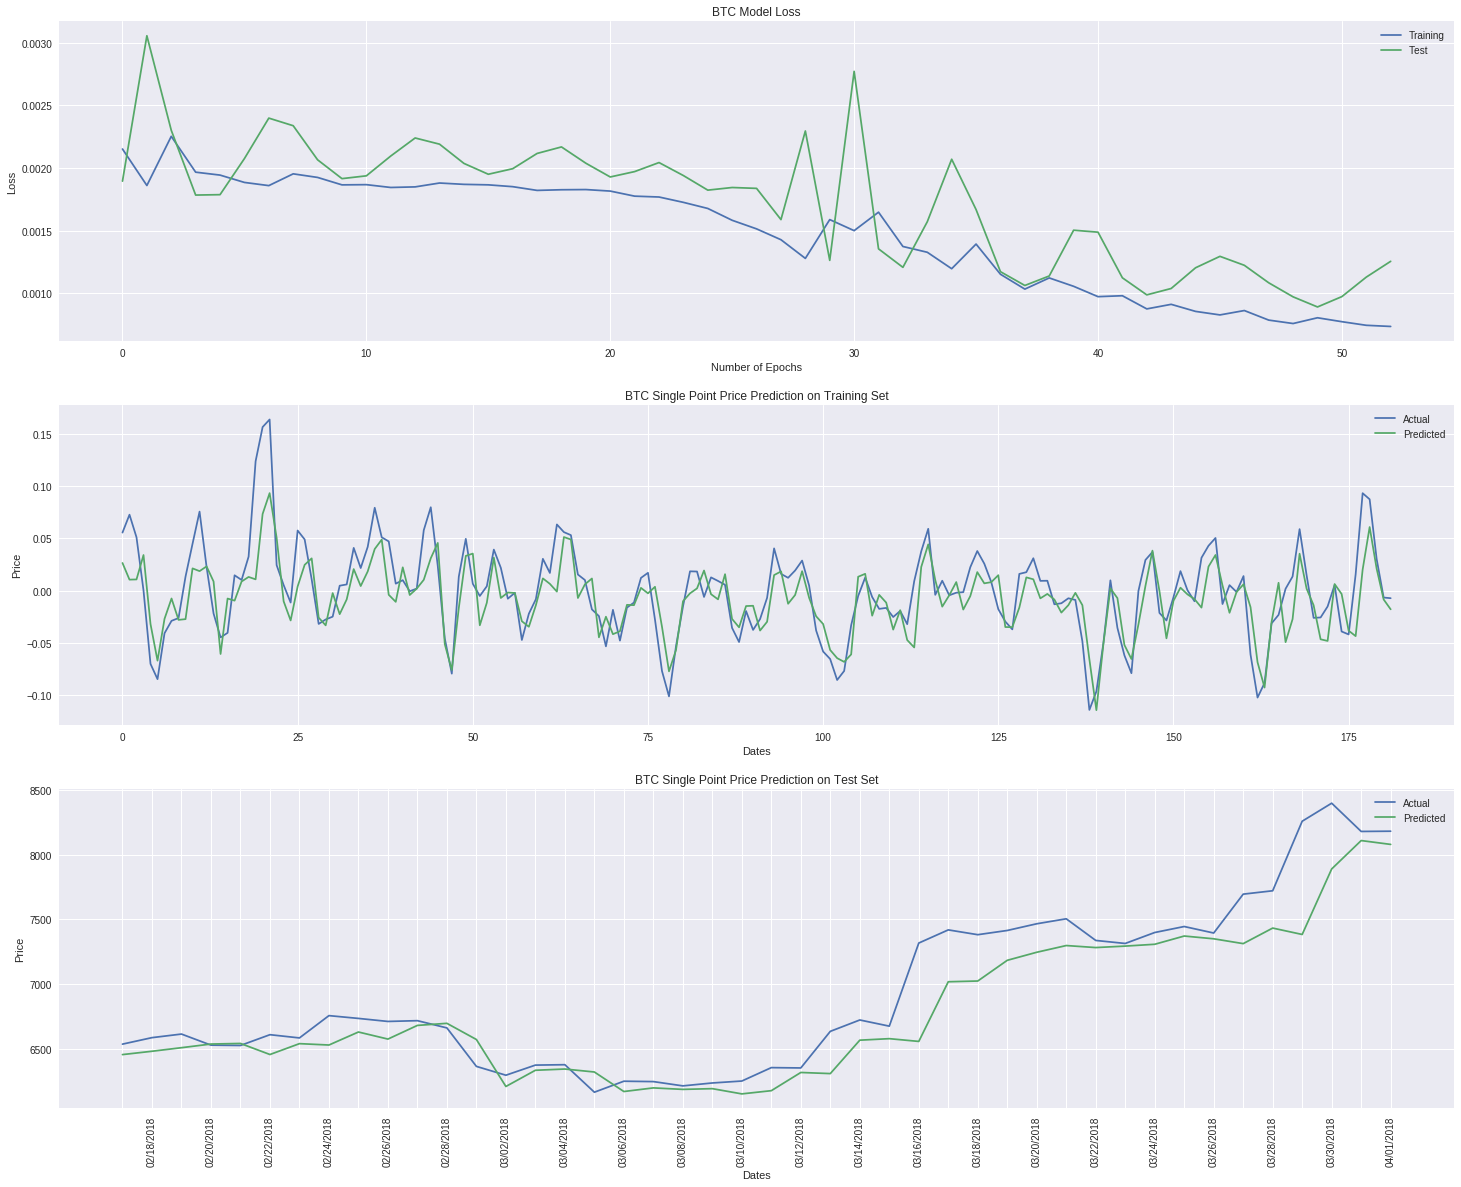

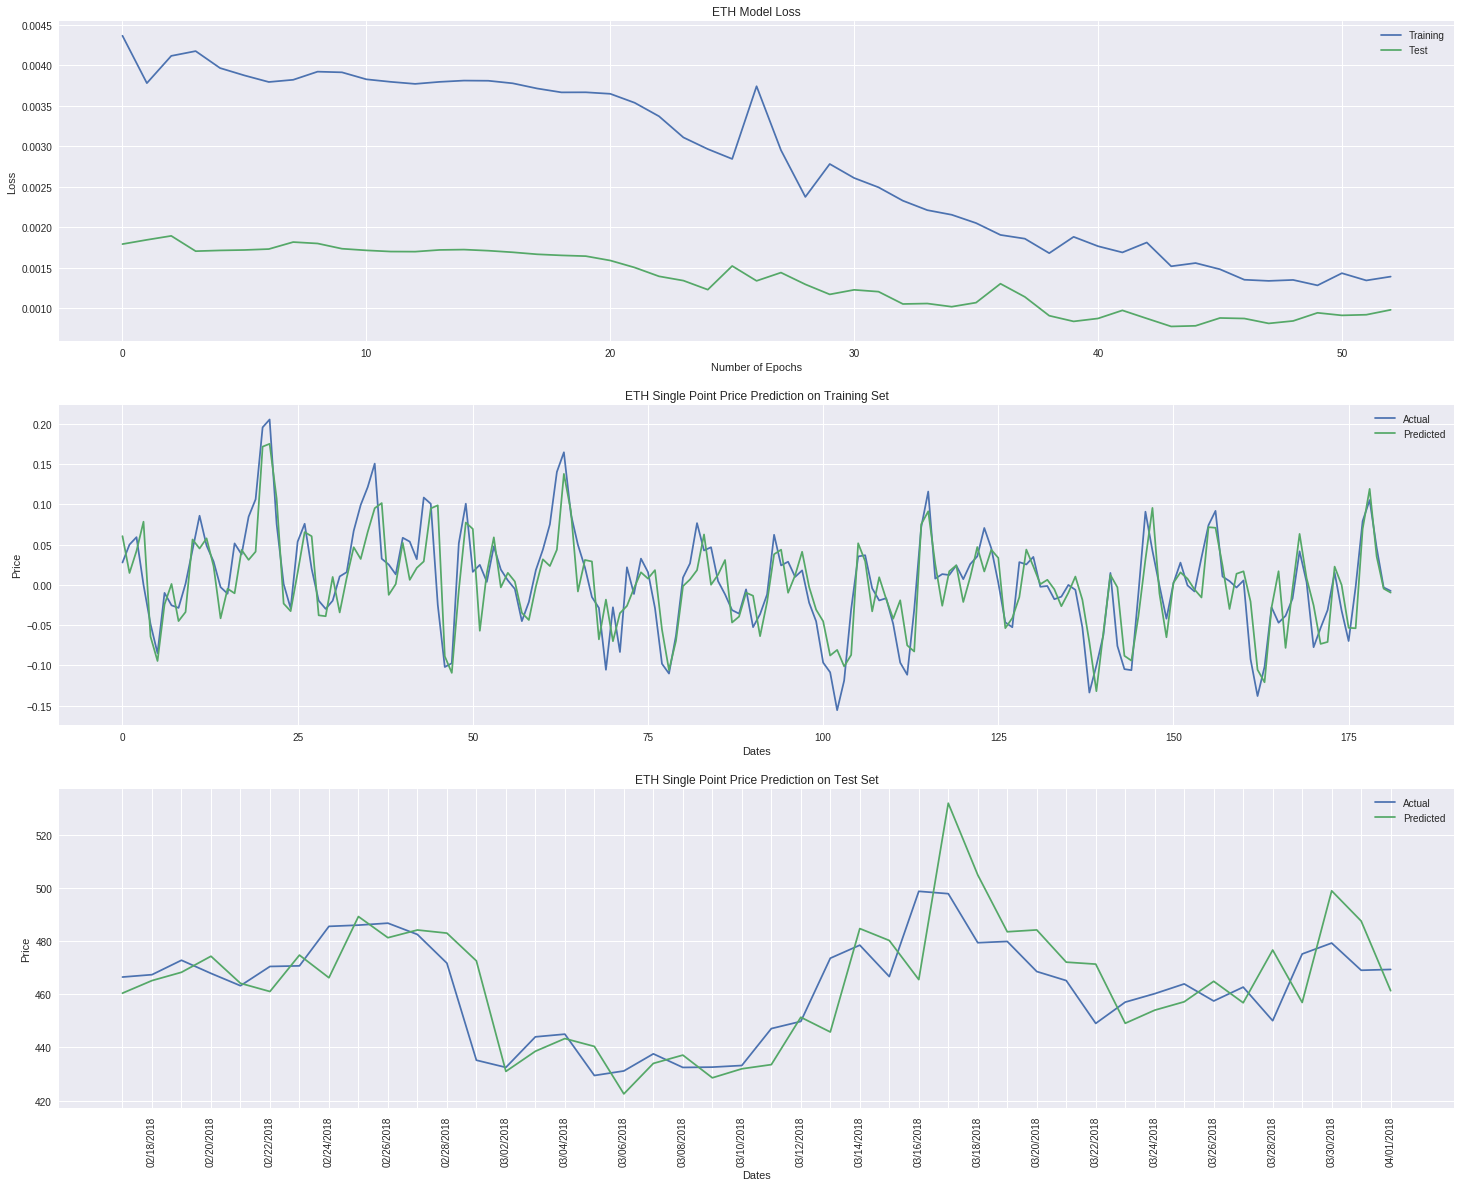

In [13]:
# clean up the memory
gc.collect()
# random seed for reproducibility
np.random.seed(202)
# initialise model architecture
btc_model = build_model(X_train, output_size=1, neurons=neurons)
eth_model = build_model(X_train, output_size=1, neurons=neurons)
# train model on data
btc_history = btc_model.fit(X_train, Y_train_btc, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_test, Y_test_btc), shuffle=False)
eth_history = eth_model.fit(X_train, Y_train_eth, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_test, Y_test_eth), shuffle=False)
plot_results(btc_history, btc_model, Y_train_btc, coin='BTC')
plot_results(eth_history, eth_model, Y_train_eth, coin='ETH')